#BA870 - Individual Project

#NAME: Christopher Chang


# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats.mstats import winsorize 

# Part I: Determine Risk Exposures

### Upload Stock Return Data and Project Tickers 



In [ ]:
df_ret = pd.read_csv('Project-2017-21-Returns.csv')
df_tic = pd.read_csv('ProjectTickers.csv')

In [ ]:
# There are missing values in the dataframe that needs to be dealt with 
df_ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114715 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PERMNO  114715 non-null  int64 
 1   date    114715 non-null  int64 
 2   TICKER  114653 non-null  object
 3   RET     114700 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.5+ MB


In [ ]:
# We will change RET variable to float format for later use in regression
df_ret['RET'] = pd.to_numeric(df_ret['RET'],errors='coerce')

In [ ]:
df_ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114715 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PERMNO  114715 non-null  int64  
 1   date    114715 non-null  int64  
 2   TICKER  114653 non-null  object 
 3   RET     114629 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.5+ MB


In [ ]:
# There are 1925 unique tickers in df_ret 
# but we want to match the 1886 unique tickers in the df_tic
len(df_ret.TICKER.unique())

1925

### Merge df_tic and df_ret to get 1886 unique tickers 

In [ ]:
df_tic.head(2)

,Ticker,Name,RetYTD
0,A,Agilent Technologies,-0.2080
1,AA,Alcoa Corp,0.4731


In [ ]:
df_ret.rename(columns={'TICKER':'Ticker'}, inplace=True)
df_ret.head(2)

,PERMNO,date,Ticker,RET
0,10026,20170131,JJSF,-0.043918
1,10026,20170228,JJSF,0.048836


In [ ]:
# now we will do a left merge with df_tic on the left side

df_ret = pd.merge(df_tic, df_ret, on = 'Ticker', how ='left')

In [ ]:
df_ret.head(2)

,Ticker,Name,RetYTD,PERMNO,date,RET
0,A,Agilent Technologies,-0.208,87432,20170131,0.074846
1,A,Agilent Technologies,-0.208,87432,20170228,0.047580


In [ ]:
# now we have 1886 unique tickers in df_ret dataframe 
len(df_ret.Ticker.unique())

1886

### Check for missing values

In [ ]:
# 11 missing in RET column 

df_ret.isna().sum()

Ticker     0
Name       0
RetYTD     0
PERMNO     0
date       0
RET       11
dtype: int64

In [ ]:
# fill in missing values in RET column with median 

df_ret['RET'] = df_ret['RET'].fillna(df_ret['RET'].median())

###Upload Fama-French monthly risk factor data

In [ ]:
ff_factors = pd.read_csv('FF-Factors-2017-2021.csv')

In [ ]:
ff_factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dateff  60 non-null     int64  
 1   mktrf   60 non-null     float64
 2   smb     60 non-null     float64
 3   hml     60 non-null     float64
 4   rf      60 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.5 KB


In [ ]:
ff_factors.head(2)

,dateff,mktrf,smb,hml,rf
0,20170131,0.0194,-0.0113,-0.0274,0.0004
1,20170228,0.0357,-0.0204,-0.0167,0.0004


In [ ]:
# Rename date column to "date" to match df_ret's "date" column

ff_factors.rename(columns={'dateff':'date'}, inplace=True)
ff_factors.head(3)

,date,mktrf,smb,hml,rf
0,20170131,0.0194,-0.0113,-0.0274,0.0004
1,20170228,0.0357,-0.0204,-0.0167,0.0004
2,20170331,0.0017,0.0113,-0.0333,0.0003


### Put all tickers into a list

In [ ]:
tics = df_ret.Ticker.unique().tolist()
len(tics)

1886

### Make empty dataframe with ticker, mktrf, smb, and hml variables

In [ ]:
final = pd.DataFrame(columns = ['TICKER', 'R-squared','Adj.R-squared','alpha','mktrf','smb','hml'])

## Risk Regression

### Create for loop that loops through all tickers and merges each ticker dataset with the Fama-French monthly risk factor data, then constructing regressions for each ticker dataset and appending elements from the regression into the empty dataframe created above

In [ ]:
# for loop that loops through all tickers
for i in tics:
  data_all = df_ret[df_ret['Ticker'] == i] 
  merged_data = pd.merge(data_all, ff_factors, on = 'date', how ='outer')

  # Regression
  y = merged_data['RET'] - merged_data['rf']
  X = merged_data[['mktrf','smb','hml']]
  X = sm.add_constant(X) # adding a constant 
  model = sm.OLS(y,X).fit()

  # Extracting elements from OLS results.  
  rsquared = model.rsquared
  adj_rsquared = model.rsquared_adj
  alpha = model.params['const']
  mktrf = model.params['mktrf']
  smb = model.params['smb']
  hml = model.params['hml']
  row = {'TICKER': i,'R-squared': rsquared, 'Adj.R-squared': adj_rsquared, 
         'alpha':alpha, 'mktrf':mktrf, 'smb':smb, 'hml':hml}

  # Create dataframe and include extracted elements 
  final = final.append(row,ignore_index=True)   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# final data output 
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TICKER         1886 non-null   object 
 1   R-squared      1886 non-null   float64
 2   Adj.R-squared  1886 non-null   float64
 3   alpha          1886 non-null   float64
 4   mktrf          1886 non-null   float64
 5   smb            1886 non-null   float64
 6   hml            1886 non-null   float64
dtypes: float64(6), object(1)
memory usage: 103.3+ KB


In [ ]:
final.isna().sum()

TICKER           0
R-squared        0
Adj.R-squared    0
alpha            0
mktrf            0
smb              0
hml              0
dtype: int64

## Check for outliers 

In [ ]:
# min and max values are extreme indicating that there are outliers 
final.describe()

,R-squared,Adj.R-squared,alpha,mktrf,smb,hml
count,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,0.382127,0.349026,0.004178,1.065373,0.667262,0.317243
std,0.185623,0.195567,0.017643,0.624564,1.232196,0.699357
min,0.002022,-0.051441,-0.079578,-6.676723,-6.286219,-3.593321
25%,0.235846,0.194909,-0.003677,0.720385,0.016011,-0.047773
50%,0.380543,0.347358,0.002600,1.007568,0.501588,0.360752
75%,0.516755,0.490867,0.009878,1.337691,1.019407,0.760726
max,0.866154,0.858983,0.433986,6.002016,31.005941,5.919490


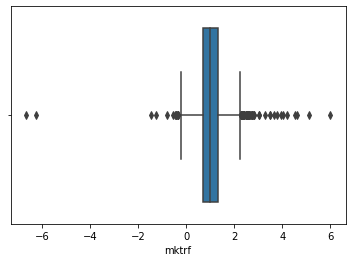

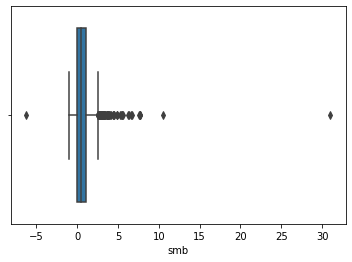

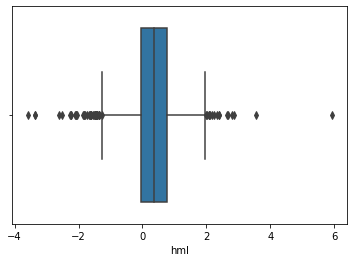

In [ ]:
# Check with boxplots 
col = ['mktrf', 'smb', 'hml']
for i in col:
  sns.boxplot(x=final[i])
  plt.show()

In [ ]:
# winsorize 

for i in col:
  final[i] = winsorize(final[i], (0.01,0.01))

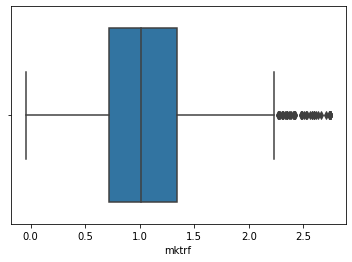

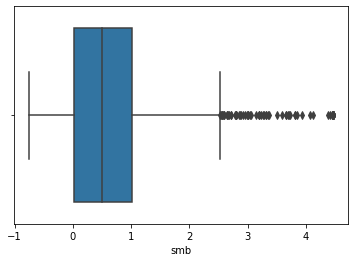

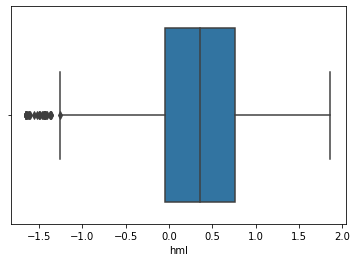

In [ ]:
# re-plot 

for i in col:
  sns.boxplot(x=final[i])
  plt.show()

In [ ]:
# check min and max values 
# outliers are a lot less extreme 

final.describe()

,R-squared,Adj.R-squared,alpha,mktrf,smb,hml
count,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,0.382127,0.349026,0.004178,1.066293,0.639361,0.316616
std,0.185623,0.195567,0.017643,0.520908,0.908463,0.651842
min,0.002022,-0.051441,-0.079578,-0.043130,-0.754144,-1.650863
25%,0.235846,0.194909,-0.003677,0.720385,0.016011,-0.047773
50%,0.380543,0.347358,0.002600,1.007568,0.501588,0.360752
75%,0.516755,0.490867,0.009878,1.337691,1.019407,0.760726
max,0.866154,0.858983,0.433986,2.745663,4.472427,1.863158


### Turn final data into CSV format required in the project instructions

In [ ]:
output = final.drop(['R-squared', 'Adj.R-squared', 'alpha'], axis = 1)

In [ ]:
output.head(2)

,TICKER,mktrf,smb,hml
0,A,1.014152,-0.253674,-0.143608
1,AA,1.984149,0.527862,1.863158


In [ ]:
output.shape

(1886, 4)

In [ ]:
# output to csv format based on project instructions 

# output.to_csv("FF-Exposures.csv")

### Graphs for Presentation

In [ ]:
figure = output.sample(10)

In [ ]:
smb = figure.sort_values(by = 'smb')

In [ ]:
mktrf = figure.sort_values(by = 'mktrf')

In [ ]:
hml = figure.sort_values(by = 'hml')

[Text(0.5, 1.0, 'Small Minus Big (SMB)')]

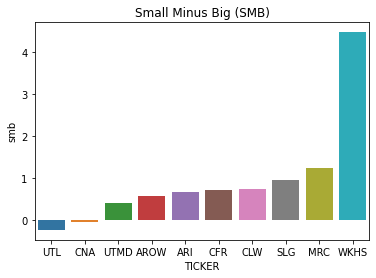

In [ ]:
sns.barplot(x = 'TICKER', y = 'smb', data = smb).set(title = 'Small Minus Big (SMB)')

[Text(0.5, 1.0, 'Market Minus Riskfree (MKTRF)')]

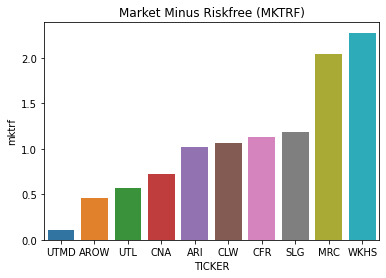

In [ ]:
sns.barplot(x = 'TICKER', y = 'mktrf', data = mktrf).set(title = 'Market Minus Riskfree (MKTRF)')

[Text(0.5, 1.0, 'High Minus Low (HML)')]

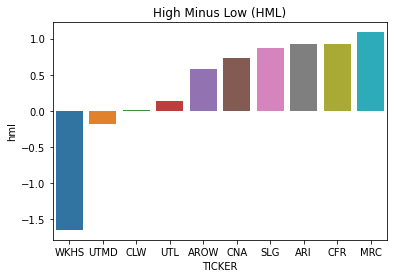

In [ ]:
sns.barplot(x = 'TICKER', y = 'hml', data = hml).set(title = 'High Minus Low (HML)')

In [ ]:
final[final['TICKER'] == 'WHR']

,TICKER,R-squared,Adj.R-squared,alpha,mktrf,smb,hml
1830,WHR,0.580464,0.557989,-0.006142,1.587596,-0.226335,0.713186


# Part II: Calculate Financial Ratios

### Import financial data

In [ ]:
df_fin = pd.read_csv('Project-2021-Financials.csv')
df_fin.head(2)

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,act,at,ceq,csho,ebit,lct,lt,ni,sale,costat,prcc_c
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,937.0,1539.7,974.4,35.375,65.5,336.8,565.3,35.8,1651.4,A,36.22
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,17336.0,66467.0,-7340.0,647.728,-5514.0,19006.0,73807.0,-1993.0,29882.0,A,17.96


In [ ]:
# There are missing values in act (total current assets), lct (total current liabilities)
# and lt (total liabilities)

print(df_fin.info())
print(df_fin.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     1886 non-null   int64  
 1   datadate  1886 non-null   int64  
 2   fyear     1886 non-null   int64  
 3   indfmt    1886 non-null   object 
 4   consol    1886 non-null   object 
 5   popsrc    1886 non-null   object 
 6   datafmt   1886 non-null   object 
 7   tic       1886 non-null   object 
 8   curcd     1886 non-null   object 
 9   act       1431 non-null   float64
 10  at        1886 non-null   float64
 11  ceq       1886 non-null   float64
 12  csho      1886 non-null   float64
 13  ebit      1886 non-null   float64
 14  lct       1431 non-null   float64
 15  lt        1881 non-null   float64
 16  ni        1886 non-null   float64
 17  sale      1886 non-null   float64
 18  costat    1886 non-null   object 
 19  prcc_c    1886 non-null   float64
dtypes: float64(10), int64(3), obje

In [ ]:
# replace lt (total liabilities) with median since there are only 5 missing  
df_fin['lt'] = df_fin['lt'].replace(np.nan, df_fin['lt'].median())

# drop act and lct because too much values are missing
df_fin.drop(['act', 'lct'], axis = 1, inplace = True)

### Merge ticker and financial data on ticker symbols

In [ ]:
# rename ticker column in df_fin to match that of df_tic's

df_fin.rename(columns={'tic':'Ticker'}, inplace=True)
df_fin.head(2)

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,Ticker,curcd,at,ceq,csho,ebit,lt,ni,sale,costat,prcc_c
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,1539.7,974.4,35.375,65.5,565.3,35.8,1651.4,A,36.22
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,66467.0,-7340.0,647.728,-5514.0,73807.0,-1993.0,29882.0,A,17.96


In [ ]:
# merge df_tic and df_fin on ticker 

df = pd.merge(df_tic, df_fin, on = 'Ticker', how ='left')
df.shape

(1886, 20)

In [ ]:
# now our data is ready to use to create financial ratios 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ticker    1886 non-null   object 
 1   Name      1886 non-null   object 
 2   RetYTD    1886 non-null   float64
 3   gvkey     1886 non-null   int64  
 4   datadate  1886 non-null   int64  
 5   fyear     1886 non-null   int64  
 6   indfmt    1886 non-null   object 
 7   consol    1886 non-null   object 
 8   popsrc    1886 non-null   object 
 9   datafmt   1886 non-null   object 
 10  curcd     1886 non-null   object 
 11  at        1886 non-null   float64
 12  ceq       1886 non-null   float64
 13  csho      1886 non-null   float64
 14  ebit      1886 non-null   float64
 15  lt        1886 non-null   float64
 16  ni        1886 non-null   float64
 17  sale      1886 non-null   float64
 18  costat    1886 non-null   object 
 19  prcc_c    1886 non-null   float64
dtypes: float64(9), int64(3), objec

### Adding ratios columns

In [ ]:
# market ratios (we will drop these and use the inverted ratios for better analysis)
df['P/E_ratio'] = (df['prcc_c']*df['csho'])/df['ni']
df['P/S_ratio'] = (df['prcc_c']*df['csho'])/df['sale']
df['P/EBIT_ratio'] = (df['prcc_c']*df['csho'])/df['ebit']
df['P/B_ratio'] = (df['prcc_c']*df['csho'])/df['ceq']

# inverted ratios (we will use these in regression)
df['E/P_ratio'] = 1/df['P/E_ratio']
df['S/P_ratio'] = 1/df['P/S_ratio']
df['EBIT/P_ratio'] = 1/df['P/EBIT_ratio']
df['B/P_ratio'] = 1/df['P/B_ratio']

# other ratios to use in regression
df['ROA'] = df['ni']/df['at'] # at is total assets 
df['Net_profit_margin'] = df['ni'] / df['sale']
df['ROE'] = df['ni']/(df['prcc_c']*df['csho']) # lt is total liabilities 
df['Earnings_per_share'] = df['ni']/df['csho']
df['Debt_ratio'] = df['lt'] / df['at'] # some sources consider debt ratio to be total liabilities / total assets
df['D/E_ratio'] = df['lt']/(df['prcc_c']*df['csho']) # debt to equity

In [ ]:
# drop columns not used in regression 
df.drop(['P/E_ratio', 'P/S_ratio', 'P/EBIT_ratio', 'P/B_ratio'], axis = 1, inplace = True)

In [ ]:
# 10 ratios created starting from row index 20
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ticker              1886 non-null   object 
 1   Name                1886 non-null   object 
 2   RetYTD              1886 non-null   float64
 3   gvkey               1886 non-null   int64  
 4   datadate            1886 non-null   int64  
 5   fyear               1886 non-null   int64  
 6   indfmt              1886 non-null   object 
 7   consol              1886 non-null   object 
 8   popsrc              1886 non-null   object 
 9   datafmt             1886 non-null   object 
 10  curcd               1886 non-null   object 
 11  at                  1886 non-null   float64
 12  ceq                 1886 non-null   float64
 13  csho                1886 non-null   float64
 14  ebit                1886 non-null   float64
 15  lt                  1886 non-null   float64
 16  ni    

### Check for outliers and/or data errors 

In [ ]:
# inspect statistical values for columns - there are missing or infinity values

df.describe()

,RetYTD,gvkey,datadate,fyear,at,ceq,csho,ebit,lt,ni,...,E/P_ratio,S/P_ratio,EBIT/P_ratio,B/P_ratio,ROA,Net_profit_margin,ROE,Earnings_per_share,Debt_ratio,D/E_ratio
count,1886.000000,1886.000000,1.886000e+03,1886.000000,1.886000e+03,1886.000000,1886.000000,1886.000000,1.886000e+03,1886.000000,...,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000,1886.000000
mean,-0.063484,62189.838282,2.021110e+07,2020.911983,2.622079e+04,5024.835206,216.216609,1309.807222,2.090633e+04,942.737848,...,0.027009,0.765997,0.060538,0.422120,0.023572,NaN,0.027009,4.408250,0.646549,1.545305
std,0.243801,67853.146760,2.954896e+02,0.283395,1.493189e+05,16277.563302,617.870176,5154.949448,1.355321e+05,4208.808452,...,0.136353,1.439881,0.130324,0.424100,0.171422,NaN,0.136353,16.994272,0.425294,2.739284
min,-0.787400,1004.000000,2.021013e+07,2020.000000,2.689900e+01,-14999.000000,1.161000,-6273.000000,1.609000e+00,-9501.000000,...,-1.891725,-0.087004,-1.334204,-2.056645,-1.759213,-inf,-1.891725,-91.318754,0.008474,0.005926
25%,-0.199450,11641.250000,2.021123e+07,2021.000000,1.291068e+03,416.276000,37.220250,48.110500,6.544948e+02,16.138750,...,0.008113,0.176223,0.019641,0.161112,0.007584,0.015657,0.008113,0.287445,0.460233,0.217034
50%,-0.086750,25281.000000,2.021123e+07,2021.000000,4.124783e+03,1109.486000,73.807500,211.177000,2.578166e+03,135.238000,...,0.036704,0.350729,0.056821,0.337004,0.034187,0.090344,0.036704,2.407403,0.633081,0.532805
75%,0.038750,125591.250000,2.021123e+07,2021.000000,1.307137e+04,3316.116500,176.940000,807.034250,8.822845e+03,554.200000,...,0.076322,0.814565,0.113822,0.613868,0.079409,0.199075,0.076322,5.229402,0.802777,1.418327
max,1.735700,317264.000000,2.021123e+07,2021.000000,3.743567e+06,259289.000000,16426.786000,108949.000000,3.449440e+06,94680.000000,...,0.898517,27.543662,0.974888,7.547555,1.484070,inf,0.898517,490.956072,9.901970,40.343655


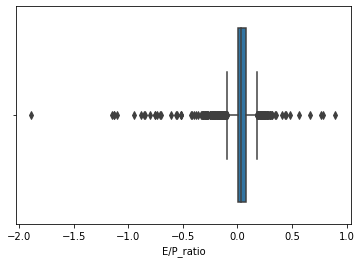

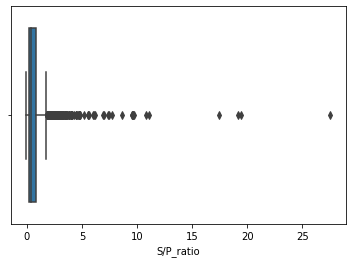

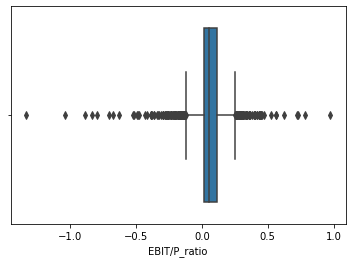

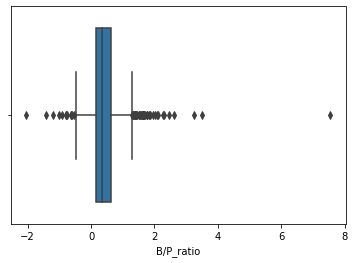

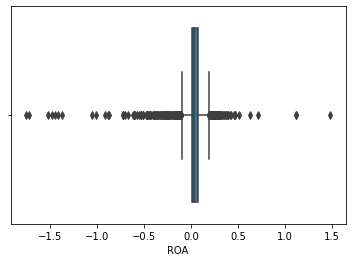

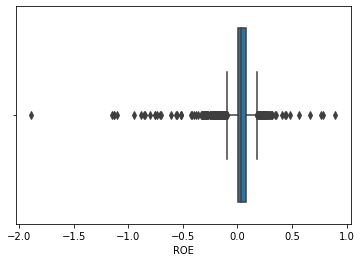

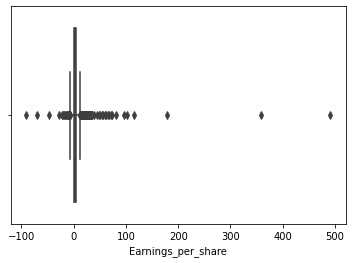

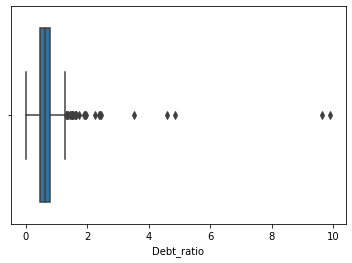

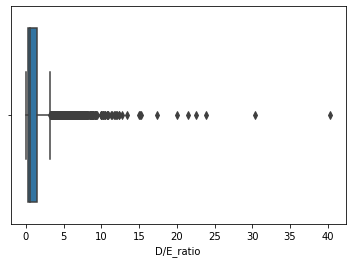

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


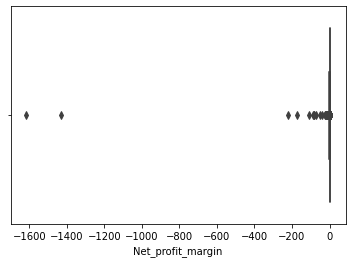

In [ ]:
# create box-plots to check outliers for ratios for regression.

columns = ['E/P_ratio', 'S/P_ratio', 'EBIT/P_ratio', 'B/P_ratio', 'ROA', 'ROE', 'Earnings_per_share',
           'Debt_ratio', 'D/E_ratio', 'Net_profit_margin']
for i in columns:
  sns.boxplot(x=df[i])
  plt.show()

In [ ]:
# winsorize outliers based on boxplot distributions

for i in columns:
  df[i] = winsorize(df[i], (0.05,0.05))

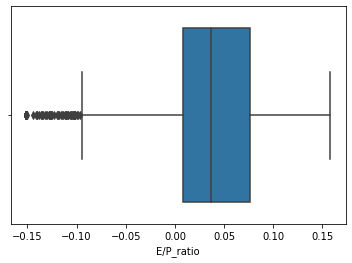

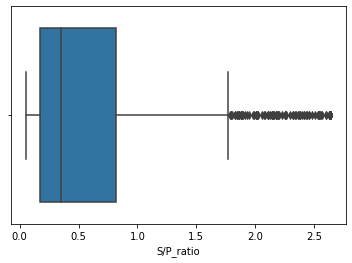

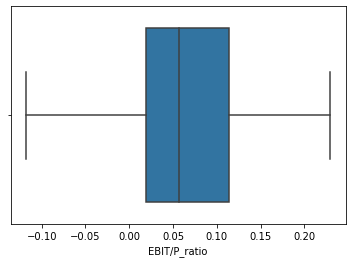

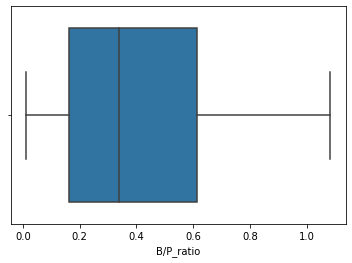

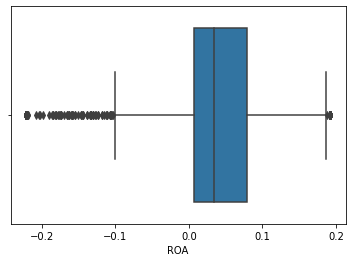

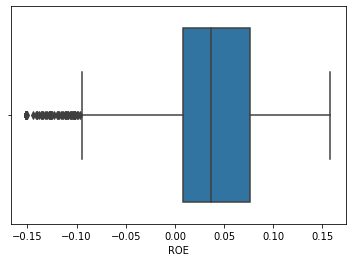

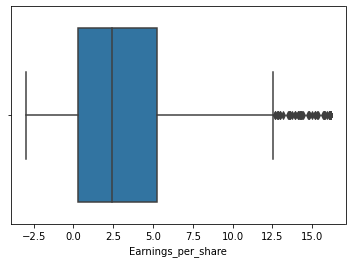

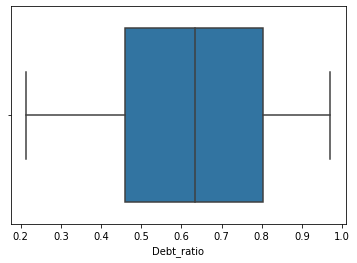

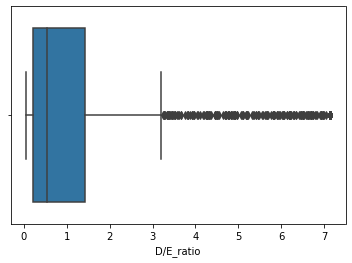

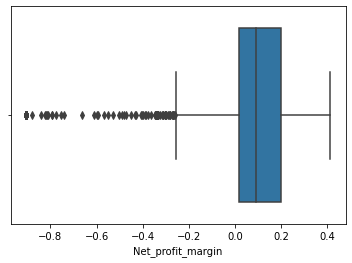

In [ ]:
# distribution improved after winsorizing 

for i in columns:
  sns.boxplot(x=df[i])
  plt.show()

In [ ]:
# create final dataset 

final_col = ['Ticker','E/P_ratio', 'S/P_ratio', 'EBIT/P_ratio', 'B/P_ratio', 
             'ROA', 'ROE', 'Earnings_per_share', 'D/E_ratio', 'Net_profit_margin',
             'Debt_ratio', 'RetYTD']
data_final = df[final_col]
data_final.head(2)

,Ticker,E/P_ratio,S/P_ratio,EBIT/P_ratio,B/P_ratio,ROA,ROE,Earnings_per_share,D/E_ratio,Net_profit_margin,Debt_ratio,RetYTD
0,A,0.025079,0.130970,0.029204,0.111695,0.113031,0.025079,4.003865,0.110182,0.191486,0.496590,-0.2080
1,AA,0.039111,1.107882,0.189357,0.425940,0.028552,0.039111,2.330255,0.796906,0.035303,0.581764,0.4731


In [ ]:
# we will use this dataset for our regression on ratios in part IV
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ticker              1886 non-null   object 
 1   E/P_ratio           1886 non-null   float64
 2   S/P_ratio           1886 non-null   float64
 3   EBIT/P_ratio        1886 non-null   float64
 4   B/P_ratio           1886 non-null   float64
 5   ROA                 1886 non-null   float64
 6   ROE                 1886 non-null   float64
 7   Earnings_per_share  1886 non-null   float64
 8   D/E_ratio           1886 non-null   float64
 9   Net_profit_margin   1886 non-null   float64
 10  Debt_ratio          1886 non-null   float64
 11  RetYTD              1886 non-null   float64
dtypes: float64(11), object(1)
memory usage: 191.5+ KB


In [ ]:
# output to csv based on project instructions

fin_ratios = data_final.drop('RetYTD', axis = 1)
# fin_ratios.to_csv("Fin-Ratios.csv")

# Part III: Industry Indicators

### Import sector dataset

In [ ]:
df_sec = pd.read_csv("Project-2021-Sector.csv")

In [ ]:
# rename date column of df_sec for merging with df_ticker
df_sec.rename(columns={'tic':'Ticker'}, inplace=True)

In [ ]:
# Merging dataset
df1 = pd.merge(df_tic, df_sec, on='Ticker', how='left')
df1.head(2)

,Ticker,Name,RetYTD,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,curcd,costat,ggroup
0,A,Agilent Technologies,-0.2080,126554,20211031,2021,INDL,C,D,STD,USD,A,3520
1,AA,Alcoa Corp,0.4731,27638,20211231,2021,INDL,C,D,STD,USD,A,1510


In [ ]:
# drop uneccessary columns 

df1 = df1.drop(columns=['Name ', 'gvkey', 'datadate', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt', 'curcd', 'costat'])

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1886 non-null   object 
 1   RetYTD  1886 non-null   float64
 2   ggroup  1886 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 58.9+ KB


In [ ]:
# get csv based on project instructions

industry = df1.drop('RetYTD', axis = 1)
# industry.to_csv("Industry.csv")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

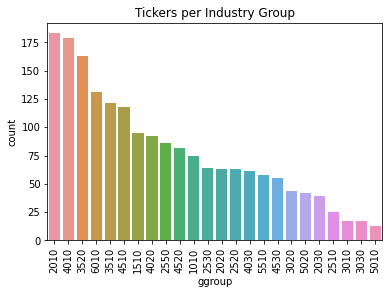

In [ ]:
# for presentation 
ind = sns.countplot(x="ggroup", data=industry, order = industry['ggroup'].value_counts().index).set(title = 'Tickers per Industry Group')
plt.xticks(rotation=90)

# Part IV: Regression

## Risk Regressions

###i. Ret(i) = a + b1*MktExposure(i) + b2*SizeExposure(i) + b3*ValueExposure(i) + e

In [ ]:
# merge two datasets ('df_tic' & 'output') on Ticker

output.rename(columns={'TICKER':'Ticker'}, inplace=True)
risk = pd.merge(df_tic, output, on='Ticker', how='left')
risk.head(2)

,Ticker,Name,RetYTD,mktrf,smb,hml
0,A,Agilent Technologies,-0.2080,1.014152,-0.253674,-0.143608
1,AA,Alcoa Corp,0.4731,1.984149,0.527862,1.863158


In [ ]:
# drop the columns 'Ticker' and 'Name '
risk = risk.drop(columns=['Ticker', 'Name '])
risk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1886 entries, 0 to 1885
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RetYTD  1886 non-null   float64
 1   mktrf   1886 non-null   float64
 2   smb     1886 non-null   float64
 3   hml     1886 non-null   float64
dtypes: float64(4)
memory usage: 73.7 KB


In [ ]:
# Regression to explain how fama french factors in general explain stock returns 

# add constant column to the original dataframe
risk['constant'] = 1
# define x2 as a subset of original dataframe
x1 = risk.drop(columns=['RetYTD'])
# Define y2 as a series
y1 = risk['RetYTD']
model1 = sm.OLS(y1, x1)
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     64.54
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           1.02e-39
Time:                        19:08:53   Log-Likelihood:                 78.629
No. Observations:                1886   AIC:                            -149.3
Df Residuals:                    1882   BIC:                            -127.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mktrf         -0.0045      0.011     -0.421      0.6

### Regression Summary 

- Ret(i) = a + b1*MktExposure(i) + b2*SizeExposure(i) + b3*ValueExposure(i) + e
- Adjusted R-squared indicates that the ff-factors mktrf, smb, and hml are only explanining 9.2% of the variation in the stock return (RetYTD).
- Coefficients indicate the amount increase/decrease in average stock returns when we increase beta by 1 unit. 
- P-value is insignificant for mktrf and smb and significant for hml and the constant (alpha).
- Looking at P-value and T-stat simultaneously, we can see that hml is the variable that explains most of the returns. 

## Financial Characteristics


###i. Ret(i) = a + b1 * Ratio1(i) + b2 * Ratio2(i) + … + b10 * Ratio10 (i) + e

In [ ]:
x2 = data_final[columns]
y2 = data_final['RetYTD']
x2 = sm.add_constant(x2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model2 = sm.OLS(y2, x2)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     23.78
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           7.57e-39
Time:                        19:08:53   Log-Likelihood:                 88.169
No. Observations:                1886   AIC:                            -156.3
Df Residuals:                    1876   BIC:                            -100.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2812      0

### Regression Summary



- Ret(i) = a + b1 * Ratio1(i) + b2 * Ratio2(i) + … + b10 * Ratio10 (i) + e
- Ratios perform slightly better than FF-factors when it comes to explaining stock returns. Adjusted R-squared (9.8%) here is greater than that of the risk regression.
- Coefficient indicate the average increase or decrease in stock returns when we increase beta by one unit. 
- Most of our ratios have significant P-values except S/P, ROA, Earnings per share, and net profit margin ratios.
- B/P ratio has the highest t-stat value which indicates the variable with the highest confidence in the coefficient as a predictor. 

## Industry Dummies

### Ret(i) = a + betas * IndustryDummies + e

In [ ]:
df1.head(2)

,Ticker,RetYTD,ggroup
0,A,-0.2080,3520
1,AA,0.4731,1510


In [ ]:
# create industry indicators for regression 

df2 = pd.get_dummies(df1, columns = ['ggroup'])
df2.head(2)

,Ticker,RetYTD,ggroup_1010,ggroup_1510,ggroup_2010,ggroup_2020,ggroup_2030,ggroup_2510,ggroup_2520,ggroup_2530,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,A,-0.2080,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AA,0.4731,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Fixed effect regression

# define x as a subset of original dataframe
x3 = df2.drop(columns=['RetYTD', 'Ticker', 'ggroup_1510'])
# add constant 
x3 = sm.add_constant(x3)
# define y as a series
y3 = df2['RetYTD']
# pass x as a dataframe, while pass y as a series
sm.OLS(y3, x3).fit().summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     39.07
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          6.29e-141
Time:                        19:08:53   Log-Likelihood:                 357.63
No. Observations:                1886   AIC:                            -667.3
Df Residuals:                    1862   BIC:                            -534.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0578      0.021      2.799      0.005       0.017       0.098
ggroup_1010     0.4572      0.031     14.692      0.000       0.396       0.518
ggroup_2010    -0.1484      0.025     -5.825      0.000      -0.198      -0.098
ggroup_2020    -0.0930      0.033     -2.841      0.005      -0.157      -0.029
ggroup_2030    -0.1253      0.038     -3.270      0.001      -0.200      -0.050
ggroup_2510    -0.2658      0.045     -5.870      0.000      -0.355      -0.177
ggroup_2520    -0.2664      0.033     -8.140      0.000      -0.331      -0.202
ggroup_2530    -0.1204      0.033     -3.697      0.000      -0.184      -0.057
ggroup_2550    -0.2091      0.030     -6.972      0.000      -0.268      -0.150
ggroup_3010     0.0205      0.053      0.386      0.700      -0.084       0.125
ggroup_3020    -0.0191      0.037     -0.519      0.604      -0.091       0.053
ggroup_3030    -0.2116      0.053     -3.989      0.000      -0.316      -0.108
ggroup_3510    -0.1243      0.028     -4.500      0.000      -0.178      -0.070
ggroup_3520    -0.2218      0.026     -8.529      0.000      -0.273      -0.171
ggroup_4010    -0.1457      0.026     -5.697      0.000      -0.196      -0.096
ggroup_4020    -0.1804      0.029     -6.121      0.000      -0.238      -0.123
ggroup_4030    -0.0541      0.033     -1.636      0.102      -0.119       0.011
ggroup_4510    -0.1665      0.028     -5.995      0.000      -0.221      -0.112
ggroup_4520    -0.2299      0.030     -7.571      0.000      -0.289      -0.170
ggroup_4530    -0.3107      0.034     -9.101      0.000      -0.378      -0.244
ggroup_5010    -0.0460      0.060     -0.772      0.440      -0.163       0.071
ggroup_5020    -0.1287      0.037     -3.448      0.001      -0.202      -0.056
ggroup_5510    -0.0171      0.034     -0.509      0.611      -0.083       0.049
ggroup_6010    -0.0937      0.027     -3.450      0.001      -0.147      -0.040
==============================================================================
Omnibus:                      403.265   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2314.656
Skew:                           0.877   Prob(JB):                         0.00
Kurtosis:                       8.136   Cond. No.                         23.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regression Summary 

- Ret(i) = a + betas * IndustryDummies + e
- Constant is the average stock return for group 1510 (Materials - chemicals/construction materials etc.), which in this case is 0.0578, indicating that the stock performance in this group is doing better than the overall stock market.
- To find group, say, 1010's (Energy industry) average stock returns, we would add alpha to group 1010's coefficient. 
- Industry indicators perform better than risk factors and financial ratios as we see the adjusted R-squared (32%) here is a lot greater than those of the other two regressions. 
- P-value is insignificant for groups 3010, 3020, 4030, 5010, and 5510. 
- T-value is highest in group 1010, indicating that group 1010 has the highest predicting power in the regression.


## Combined Regressions

In [ ]:
# Risk 
output.head(2)

,Ticker,mktrf,smb,hml
0,A,1.014152,-0.253674,-0.143608
1,AA,1.984149,0.527862,1.863158


In [ ]:
# Financial ratios 
fin_ratios.head(2)

,Ticker,E/P_ratio,S/P_ratio,EBIT/P_ratio,B/P_ratio,ROA,ROE,Earnings_per_share,D/E_ratio,Net_profit_margin,Debt_ratio
0,A,0.025079,0.130970,0.029204,0.111695,0.113031,0.025079,4.003865,0.110182,0.191486,0.496590
1,AA,0.039111,1.107882,0.189357,0.425940,0.028552,0.039111,2.330255,0.796906,0.035303,0.581764


In [ ]:
# Industry Indicators 
df1.head(2)

,Ticker,RetYTD,ggroup
0,A,-0.2080,3520
1,AA,0.4731,1510


In [ ]:
# Merge all three datasets together on ticker

combined = pd.merge(output, fin_ratios, on = 'Ticker', how = 'left')
combined = pd.merge(combined, df1, on = 'Ticker', how = 'left')
combined.drop('Ticker', axis =1, inplace = True)

In [ ]:
combined.head(2)

,mktrf,smb,hml,E/P_ratio,S/P_ratio,EBIT/P_ratio,B/P_ratio,ROA,ROE,Earnings_per_share,D/E_ratio,Net_profit_margin,Debt_ratio,RetYTD,ggroup
0,1.014152,-0.253674,-0.143608,0.025079,0.130970,0.029204,0.111695,0.113031,0.025079,4.003865,0.110182,0.191486,0.496590,-0.2080,3520
1,1.984149,0.527862,1.863158,0.039111,1.107882,0.189357,0.425940,0.028552,0.039111,2.330255,0.796906,0.035303,0.581764,0.4731,1510


In [ ]:
# get_dummies
combined = pd.get_dummies(combined, columns=['ggroup'])
combined.head(2)

,mktrf,smb,hml,E/P_ratio,S/P_ratio,EBIT/P_ratio,B/P_ratio,ROA,ROE,Earnings_per_share,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,1.014152,-0.253674,-0.143608,0.025079,0.130970,0.029204,0.111695,0.113031,0.025079,4.003865,...,0,0,0,0,0,0,0,0,0,0
1,1.984149,0.527862,1.863158,0.039111,1.107882,0.189357,0.425940,0.028552,0.039111,2.330255,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Combined Regression 

x4 = combined.drop(columns=['RetYTD'])

# add constant 
x4 = sm.add_constant(x4)

# Define y2 as a series
y4 = combined['RetYTD']
model4 = sm.OLS(y4, x4)
results4 = model4.fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:                 RetYTD   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     33.48
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          1.54e-169
Time:                        19:08:54   Log-Likelihood:                 448.99
No. Observations:                1886   AIC:                            -826.0
Df Residuals:                    1850   BIC:                            -626.5
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1519      0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Regression Summary 

- Combining risk, ratios, and industry indicators into one regression, we can see that the Adjusted R-squared (38%) is the highest compared to those of the individual regressions. 
- Industry indicators do better than other indicators when explaining stock returns. 

# Summary and Recommendation

### **Summary** 
In this project I did analysis on stock returns during the early 2022 market shock using three kinds of indicators: Risk factors, Financial ratios, and Industry groups. Results from regression indicate that industry indicators perform best when it comes to explaining stock returns, with the highest adjusted r-squared among the three. Furthermore, R-squared increased after combining all three indicators. 

### **Recommendation**

Based on the models, it is plausible to say that one should: 
*   Invest in energy stocks (Oil, gas, consumable fuels) and avoid semiconductor stocks. 
*   Not put all eggs in one basket. - You cannot accurately predict if energy stocks can make 52% returns
*   Use Earnings/Price, EBIT/Price, Book/Price, ROE, Debt, Debt/Equity financial ratios to evaluate stock returns for companies. 









# Convert to PDF from HTML

In [ ]:
# html-pdf
# !jupyter nbconvert --to html /content/BA870_Individual_Project.ipynb

[NbConvertApp] Converting notebook /content/BA870_Individual_Project.ipynb to html
[NbConvertApp] Writing 683288 bytes to /content/BA870_Individual_Project.html
